This kernel is an abstractive text summarizer that attempts to create novel summaries of Covid-19 research articles. We train on articles using their abstracts as targets, test on articles without abstracts. 

*** Colab crashes if articles are over 1000 in length. only 18% of the articles are < 1000. this is a problem***
- ideas:
  - pay for a better service
  - split the articles into batches of len 800 and give them the same abstract
    - frank had the idea that we would have to put the snippets back together. 
    - test with splits of 800 and compare to performance if we recombine the snippets.
  - try on local machine before paying for anything


# Imports

In [1]:
import tensorflow as tf
import numpy as np
import nltk
import pandas as pd 
import re
import json
import os
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Layer, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
data1=pd.read_csv('articles/data_b1.csv')
data2=pd.read_csv('articles/data_b2.csv')
data3=pd.read_csv('articles/data_b3.csv')
data4=pd.read_csv('articles/data_b4.csv')
data5=pd.read_csv('articles/data_b5.csv')
data6=pd.read_csv('articles/data_b6.csv')
data7=pd.read_csv('articles/data_b7.csv')
data8=pd.read_csv('articles/data_bL.csv')

In [3]:
frames = [data1,data2,data3,data4,data5,data6,data7,data8]

In [4]:
data = pd.concat(frames)

In [5]:
del data1, data2, data3, data4, data5, data6, data7, data8, frames

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       11511 non-null  int64 
 1   Text             11511 non-null  object
 2   Summary          11511 non-null  object
 3   cleaned_text     11511 non-null  object
 4   cleaned_summary  11511 non-null  object
dtypes: int64(1), object(4)
memory usage: 539.6+ KB


# Covid19Sum Dataset

## The metadata

In [7]:
# data_dir = "/content/drive/Shared drives/Abstractive Text Summarization/metadata.csv"
# meta=pd.read_csv(data_dir)

## Data collection and preprocessing

The pdf articles have abstracts, while the xml articles do not.

In [8]:
# #PDF articles (for training)
# os.chdir("/content/drive/Shared drives/Covid Summary Data/covid sum sample pdf")
# print(len(os.listdir()))

In [9]:
#XML articles (for testing)
# os.chdir("/content/drive/Shared drives/Abstractive Text Summarization/covid sum sample")
# os.listdir()

Here we parse the body of the articles and the abstracts

In [10]:
# #articles for train
# articles_abstract = list()
# articles_body = list()
# for i in os.listdir():
#  # print(i)
#   with open(i) as json_file:
#     itemDataPDF = json.load(json_file)
#     text_collection_body = ""
#     text_collection_abstract = ""
#     for body_text in itemDataPDF['body_text']:
#       # cov_test1.append(text['text'])
#      # print(body_text['text'])
#       text_collection_body = text_collection_body + body_text["text"]
#     for abs_text in itemDataPDF['abstract']:
#      # print(abs_text['text'])
#       text_collection_abstract = text_collection_abstract + abs_text['text']
#   articles_body.append(text_collection_body)
#   articles_abstract.append(text_collection_abstract)

#   # break;
# # with open('PMC442122.xml.json') as json_file:
# #     itemData = json.load(json_file)


In [11]:
# print(articles_abstract[1])

In [12]:
#the body still has the section attatched. need to remove
# print(articles_body[1])

In [13]:
# #checking that number of articles and abstracts match 
# #if they do not match, more processing is needed
# print('number of abstracts',len(articles_abstract))
# print('number of articles',len(articles_body))

In [14]:
#change to np array
# articles = np.array(articles_body)
# summary = np.array(articles_abstract)

# AttentionLayer

In [15]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Creating Dataframe

In [16]:
# #creates "nice" string? not sure if this is necessary
# def to_string_trim(line):
#   return str(line)[2:-2]

In [17]:
# X_test = np.array(list(map(to_string_trim, np.array(articles_body))))
# y_test = np.array(list(map(to_string_trim, np.array(articles_abstract))))

In [18]:
# X_test = np.array(list(map(to_string_trim, articles)))
# y_test = np.array(list(map(to_string_trim, summary)))


In [19]:
# data = pd.DataFrame({"Text":X_test, "Summary":y_test})

In [20]:
# data.info()

# Preprocessing


Some of the preprocessing may be redundant. Not sure if contraction_mapping is necssary, research articles shouldn't have many contractions.

In [21]:
# contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
#                            "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
#                            "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
#                            "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
#                            "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
#                            "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
#                            "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
#                            "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
#                            "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
#                            "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
#                            "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
#                            "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
#                            "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
#                            "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
#                            "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
#                            "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
#                            "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
#                            "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
#                            "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
#                            "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
#                            "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
#                            "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
#                            "you're": "you are", "you've": "you have"}

In [22]:
# #removes HTML tags no necessary, contraction mapping?,
# # remove('s) and parenthesis may be useful
# import nltk
# nltk.download('stopwords')

# stop_words = set(stopwords.words('english')) 

# def text_cleaner(text,num):
#     newString = text.lower()
#     newString = BeautifulSoup(newString, "lxml").text
#     newString = re.sub(r'\([^)]*\)', '', newString)
#     newString = re.sub('"','', newString)
#     newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
#     newString = re.sub(r"'s\b","",newString)
#     newString = re.sub("[^a-zA-Z]", " ", newString) 
#     newString = re.sub('[m]{2,}', 'mm', newString)
#     if(num==0):
#         tokens = [w for w in newString.split() if not w in stop_words]
#     else:
#         tokens=newString.split()
#     long_words=[]
#     for i in tokens:
#         if len(i)>1:                                                 #removing short word
#             long_words.append(i)   
#     return (" ".join(long_words)).strip()

In [23]:
# #call the function
# cleaned_text = []
# for t in data['Text']:
#     cleaned_text.append(text_cleaner(t,0)) 

In [24]:
# cleaned_text[:5]  

In [25]:
# #call the function
# cleaned_summary = []
# for t in data['Summary']:
#     cleaned_summary.append(text_cleaner(t,1))

In [26]:
# cleaned_summary[:10]

In [27]:
# data['cleaned_text']=cleaned_text
# data['cleaned_summary']=cleaned_summary

shouldnt have any empty rows, but just incase:
*turns out its needed*

In [28]:
# data.replace('', np.nan, inplace=True)
# data.dropna(axis=0,inplace=True)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       11511 non-null  int64 
 1   Text             11511 non-null  object
 2   Summary          11511 non-null  object
 3   cleaned_text     11511 non-null  object
 4   cleaned_summary  11511 non-null  object
dtypes: int64(1), object(4)
memory usage: 539.6+ KB


In [30]:
# with open('/content/drive/Shared drives/Abstractive Text Summarization/data.csv', 'w') as f:
#   data.to_csv(f)

# Data info

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11511 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       11511 non-null  int64 
 1   Text             11511 non-null  object
 2   Summary          11511 non-null  object
 3   cleaned_text     11511 non-null  object
 4   cleaned_summary  11511 non-null  object
dtypes: int64(1), object(4)
memory usage: 539.6+ KB


In [32]:
for i in range(5):
  print("Article", i+1)
  print(data['cleaned_text'][i])
  print('-'*100)
  print(data['cleaned_summary'][i])

Article 1
0    use personal protective equipment central behavioural policy response control spread sars cov virus global covid pandemic particular masks sometimes gloves aprons gowns face eye protection recomme...
0    document written request parisarea healthcare authorities france guidance intended help professionals coordinate patients pathways standardize practices among centers avoid acting first come first...
0    historically pacific island countries territories severely affected influenza pandemics part world extreme example influenza pandemic western samoa experienced loss population hand also pandemic f...
0    drug metabolism experiment played important role drug discovery drug design drug clinical application therefore fast efficient ways provide accurate information drug metabolism target compounds ma...
0    date italy experiencing severe outbreak covid infection largely unexpected death rate consequence entire nation global lockdown contain virus spread since february e

Name: cleaned_text, dtype: object
----------------------------------------------------------------------------------------------------
3    background in this study we assess how effective pandemic and trivalent seasonal vaccines were in preventing influenza like illness during the pandemic in france we also compare vaccine effectiven...
3    houttuynia cordata injection is traditional chinese medicine used in china it was chosen as one of eight types of traditional chinese medicine that play unique role in severe acute respiratory syn...
3    this review draws pragmatic lessons for developing countries to address covid induced recessions and to sustain developmental recovery these recessions are unique caused initially by supply disrup...
3    mediastinal compression syndromes due to idiopathic fibrosing mediastinitis report of three cases and review of the literature thorac cardiovasc surg dehner lp coffin cm idiopathic fibrosclerotic ...
3    more and more asset management organizat

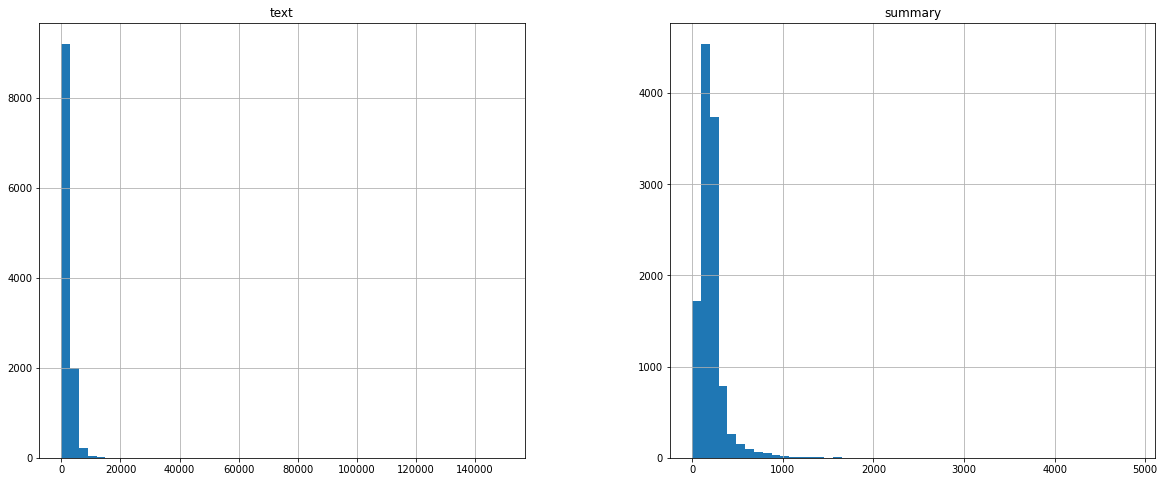

In [33]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 50)
plt.show()

In [34]:
#propotion of length of summaries
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=400):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9394492224828425


In [35]:
#propotion of length of summaries
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=4000):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9063504473981409


In [36]:
data.head()

,Unnamed: 0,Text,Summary,cleaned_text,cleaned_summary
0,1,"Use of Personal Protective Equipment (PPE) has been a central behavioural and policy response to control spread of the SARS-CoV2 virus during the global COVID-19 pandemic. In particular masks, and...","Use of Personal Protective Equipment (PPE) has been central to controlling spread of SARS-CoV2. This study aims to quantify the environmental impact of this, and to model strategies for its reduct...",use personal protective equipment central behavioural policy response control spread sars cov virus global covid pandemic particular masks sometimes gloves aprons gowns face eye protection recomme...,use of personal protective equipment has been central to controlling spread of sars cov this study aims to quantify the environmental impact of this and to model strategies for its reduction life ...
1,2,"We developed a deterministic compartmental transmission model of SARS-CoV-2 in a population stratified by disease status (susceptible, exposed, infectious with mild or severe disease, diagnosed, a...",The coronavirus disease caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) has spread to nearly every country in the world since it first emerged in China in December 2019....,developed deterministic compartmental transmission model sars cov population stratified disease status disease awareness status due spread covid self imposed measures assumed taken diseaseaware in...,the coronavirus disease caused by the severe acute respiratory syndrome coronavirus has spread to nearly every country in the world since it first emerged in china in december many countries have ...
2,5,COVID-19 spread within 3 months to 210 countries across the globe. The progression of COVID-19 pandemic in each country is estimated by the daily report compiled by the World Health Organization (...,"COVID-19 started in Hubei province in China and has spread to 210 countries within 3 months. The statistic of COVID-19 across the world is reported daily, providing a dynamic perspective for each ...",covid spread within months countries across globe progression covid pandemic country estimated daily report compiled world health organization publically available worldometers online resource cou...,covid started in hubei province in china and has spread to countries within months the statistic of covid across the world is reported daily providing dynamic perspective for each country we teste...
3,6,"Estimating the field effectiveness of influenza vaccines (VE) poses specific challenges for the 2009 A(H1N1) pandemic. In particular, both pandemic and seasonal vaccination campaigns took place du...","Background: In this study, we assess how effective pandemic and trivalent 2009-2010 seasonal vaccines were in preventing influenza-like illness (ILI) during the 2009 A(H1N1) pandemic in France. We...",estimating field effectiveness influenza vaccines poses specific challenges pandemic particular pandemic seasonal vaccination campaigns took place epidemic consequence vaccine coverage changed tim...,background in this study we assess how effective pandemic and trivalent seasonal vaccines were in preventing influenza like illness during the pandemic in france we also compare vaccine effectiven...
4,7,"COVID-19 pandemic reached 3.78 million confirmed reported cases worldwide, and it is generally associated to the acronym that precedes its name: severe acute respiratory syndrome (SARS). However, ...","Due to its extreme virulence, COVID-19 virus has rapidly spread, developing a severe pandemic. SARS-COV-2 mostly affected the respiratory tract, causing a severe acute lung failure. Although the i...",covid pandemic reached million confirmed reported cases worldwide generally associated acronym precedes name severe acute respiratory syndrome however bottom iceberg progressively unveiled since f...,due to its extreme virulence covid virus has rapidly spread developing severe pandemic sars cov mostly affecte

In [37]:
#**change to fit data set**
max_text_len=4000
max_summary_len=400 # this should be 100

In [38]:
#selecting summaries of desired length
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

In [39]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [40]:
df['text']

0       use personal protective equipment central behavioural policy response control spread sars cov virus global covid pandemic particular masks sometimes gloves aprons gowns face eye protection recomme...
1       developed deterministic compartmental transmission model sars cov population stratified disease status disease awareness status due spread covid self imposed measures assumed taken diseaseaware in...
2       covid spread within months countries across globe progression covid pandemic country estimated daily report compiled world health organization publically available worldometers online resource cou...
3       estimating field effectiveness influenza vaccines poses specific challenges pandemic particular pandemic seasonal vaccination campaigns took place epidemic consequence vaccine coverage changed tim...
4       covid pandemic reached million confirmed reported cases worldwide generally associated acronym precedes name severe acute respiratory syndrome however bottom ic

In [41]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.3,random_state=0,shuffle=True) 

# Tokenizer

In [42]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [43]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 63.93158307594254
Total Coverage of rare words: 1.2099514278455907


In [44]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [45]:
x_voc

58856

# Summary Tokenizer

In [46]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [47]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.41718911388149
Total Coverage of rare words: 4.322686425676395


In [48]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [49]:
#y_voc size seems too small.
#first try increasing number of articles
y_voc

11484

In [50]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(6904, 6904)

Delete start and end tokens

In [51]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [52]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# The Model

In [53]:
#can also use go_backwards = true for a layer or two

from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
bi_LSTM = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,
                             dropout=0.5,recurrent_dropout=0.5),merge_mode='concat' )(enc_emb)

encoder_output0, state_h0, state_c0, backward_h, backward_c =Bidirectional(LSTM(latent_dim, return_state=True), 
                               merge_mode="concat", name='bi')(bi_LSTM)

#econder_output0 = tf.expand_dims(encoder_output0, axis=-1)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.5)
encoder_outputs, state_h, state_c = encoder_lstm1(tf.expand_dims(encoder_output0, axis=-1)) #expanded dim of bi_lstm

#econder_output1 = tf.expand_dims(encoder_output1, axis=-1)

#encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.5)
# encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

#encoder lstm 3
#(consider bidirectinal layer pg. 546 in Geron)
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='elu')) #try elu***
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 4000, 100)    5885600     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 4000, 400),  481600      embedding[0][0]                  
__________________________________________________________________________________________________
bi (Bidirectional)              [(None, 400), (None, 961600      bidirectional[0][0]              
                                                                 bidirectional[0][1]   

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,batch_size=16, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5


In [ ]:
#plot training
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encoder/Decoder

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        #print('here')
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)

    #***for some reason the decoder breaks when sampled_token_index=0 t
        if(sampled_token_index == 0):sampled_token_index = sampled_token_index+1
    #****
        sampled_token = reverse_target_word_index[sampled_token_index]
        #sampled_token = reverse_source_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

In [ ]:
# from google.colab import files
# files.download('/var/log/colab-jupyter.log') 